In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deeplake[enterprise]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 110.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 117.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.7 MB/s et

In [ ]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [36]:
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')
test_ds, _ = test_ds.random_split([0.25, 0.75])

\

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



\

hub://activeloop/nih-chest-xray-test loaded successfully.



In [37]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomRotation(8),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [6]:
def eval_one_epoch(model, criterion, data_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  running_val_loss = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      all_preds.append(outputs.sigmoid())
      all_labels.append(labels)

      loss = criterion(outputs, labels)
      running_val_loss += loss.item() * inputs.shape[0]

  val_average_loss = running_val_loss / len(data_loader.dataset)
  print(f'Validation phase completed. Average loss: {val_average_loss:.4f}')

  all_preds = torch.cat(all_preds, dim=0)
  all_labels = torch.cat(all_labels, dim=0)

  all_preds = all_preds.cpu().numpy()
  all_labels = all_labels.cpu().numpy()

  micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
  print(f'Micro-averaged ROC AUC: {micro_auc_score}')

  macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
  print(f'Macro-averaged ROC AUC: {macro_auc_score}')

  num_labels = all_labels.shape[1]
  plt.figure(figsize=(10, 8))

  per_class_auc_scores = []

  for label_index in range(num_labels):
    try:
      auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
      per_class_auc_scores.append(auc_score)
      print(f'ROC AUC for label {label_index}: {auc_score}')

      fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
      plt.plot(fpr, tpr, label=f'Label {label_index} (AUC = {auc_score:.2f})')
    except ValueError:
      print(f'ROC AUC for label {label_index}: Not Defined (No positive examples in labels)')
      per_class_auc_scores.append(None)

  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')
  plt.legend(loc="lower right")
  plt.show()

  return val_average_loss, micro_auc_score, macro_auc_score, per_class_auc_scores

In [7]:
def class_averaged_binary_cross_entropy(preds, targets):
  num_classes = 15
  loss = 0

  for c in range(num_classes):
    loss_c = F.binary_cross_entropy(preds[:, c], targets[:, c])
    loss += loss_c

  loss /= num_classes

  return loss

In [8]:
def load_model(result_file_model, model_to_load, model, epoch, device):
    model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f'Model loaded from {model_save_path}')
    return model

In [38]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model.fc.in_features
num_labels = 15

model.fc = nn.Sequential(
  nn.Linear(2048, 1000),
  nn.ReLU(),
  nn.Linear(1000, num_labels),
  nn.Softmax(dim=1)
)

In [39]:
model_name = "SSN_BCE_Avg_Loss_Balanced_ResNet50"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models"
epoch = 1

criterion = class_averaged_binary_cross_entropy

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

loaded_model = load_model(result_file_model, model_name, model, epoch, device)
loaded_model.to(device)

Running on cuda
Model loaded from /content/drive/MyDrive/SSN_Projekt/Saved_Models/SSN_BCE_Avg_Loss_Balanced_ResNet50_checkpoint_epoch_1.pt


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Validation phase completed. Average loss: 0.2698
Micro-averaged ROC AUC: 0.8054215108035121
Macro-averaged ROC AUC: 0.6498932492910429
ROC AUC for label 0: 0.6949363788612222
ROC AUC for label 1: 0.646642719304364
ROC AUC for label 2: 0.6959291266136453
ROC AUC for label 3: 0.5658356392655669
ROC AUC for label 4: 0.5914401757119894
ROC AUC for label 5: 0.6817913873290584
ROC AUC for label 6: 0.5030522581258422
ROC AUC for label 7: 0.7548970438486712
ROC AUC for label 8: 0.5711285752981398
ROC AUC for label 9: 0.6300746835880369
ROC AUC for label 10: 0.6381312948894571
ROC AUC for label 11: 0.6980093918266986
ROC AUC for label 12: 0.7196145438590535
ROC AUC for label 13: 0.6301149663308806
ROC AUC for label 14: 0.7268005545130163


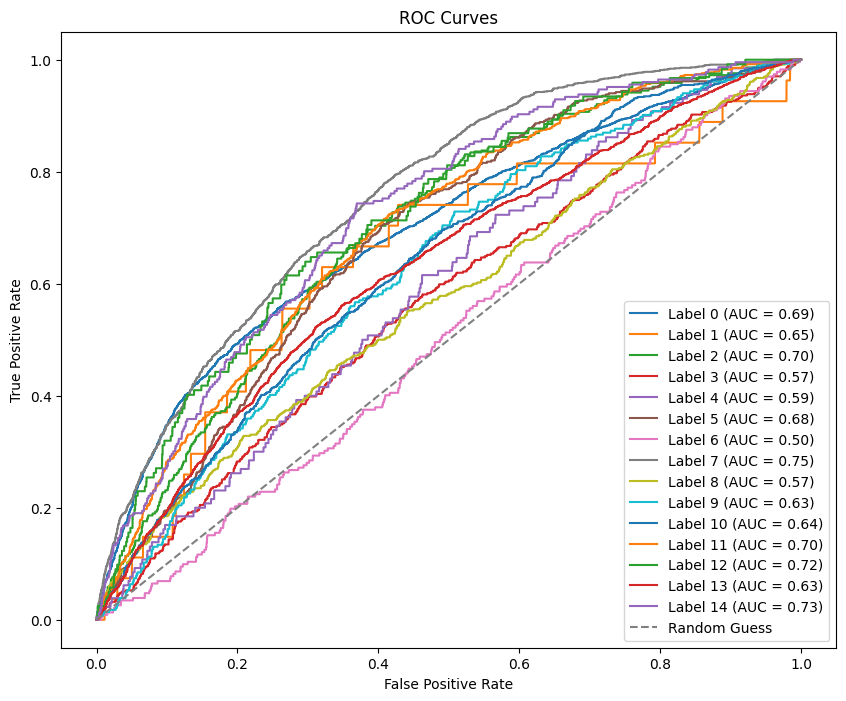

(0.26976478705277274,
 0.8054215108035121,
 0.6498932492910429,
 [0.6949363788612222,
  0.646642719304364,
  0.6959291266136453,
  0.5658356392655669,
  0.5914401757119894,
  0.6817913873290584,
  0.5030522581258422,
  0.7548970438486712,
  0.5711285752981398,
  0.6300746835880369,
  0.6381312948894571,
  0.6980093918266986,
  0.7196145438590535,
  0.6301149663308806,
  0.7268005545130163])

In [ ]:
eval_one_epoch(model, criterion, test_loader, device)

In [ ]:
def calculate_mse(model, data_loader, device):
    model.eval()
    mse_loss = nn.MSELoss()
    total_loss = 0
    num_samples = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = mse_loss(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            num_samples += inputs.size(0)

    average_loss = total_loss / num_samples
    return average_loss

In [ ]:
mse = calculate_mse(model, test_loader, device)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.0763


In [ ]:
def calculate_mse_per_label(model, data_loader, device):
    model.eval()
    mse_loss = nn.MSELoss(reduction='none')
    total_losses = torch.zeros(15, device=device)
    num_samples = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            losses = mse_loss(outputs, labels)
            total_losses += torch.sum(losses, dim=0)
            num_samples += inputs.size(0)

    average_losses = total_losses / num_samples
    return average_losses

In [ ]:
mse_per_label = calculate_mse_per_label(model, test_loader, device)
for label_index, mse in enumerate(mse_per_label):
    print(f"Mean Squared Error (MSE) for Label {label_index}: {mse:.4f}")

Mean Squared Error (MSE) for Label 0: 0.2082
Mean Squared Error (MSE) for Label 1: 0.0042
Mean Squared Error (MSE) for Label 2: 0.0434
Mean Squared Error (MSE) for Label 3: 0.0642
Mean Squared Error (MSE) for Label 4: 0.0199
Mean Squared Error (MSE) for Label 5: 0.0670
Mean Squared Error (MSE) for Label 6: 0.0352
Mean Squared Error (MSE) for Label 7: 0.1414
Mean Squared Error (MSE) for Label 8: 0.0670
Mean Squared Error (MSE) for Label 9: 0.0426
Mean Squared Error (MSE) for Label 10: 0.1127
Mean Squared Error (MSE) for Label 11: 0.0906
Mean Squared Error (MSE) for Label 12: 0.0186
Mean Squared Error (MSE) for Label 13: 0.1959
Mean Squared Error (MSE) for Label 14: 0.0339


In [11]:
def collect_pred_test(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.5).int()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    return all_preds, all_labels

In [12]:
all_pred, all_test = collect_pred_test(model, test_loader, device)

In [13]:
all_pred[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [14]:
all_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [17]:
from sklearn.metrics import multilabel_confusion_matrix

labels = ["No Finding",
          "Hernia",
          "Emphysema",
          "Nodule",
          "Pneumonia",
          "Consolidation",
          "Cardiomegaly",
          "Effusion",
          "Mass",
          "Pleural_Thickening",
          "Atelectasis",
          "Pneumothorax",
          "Fibrosis",
          "Infiltration",
          "Edema"
          ]
cm = multilabel_confusion_matrix(all_test, all_pred)

In [19]:
cm

array([[[3475,  510],
        [1437,  977]],

       [[6378,    0],
        [  21,    0]],

       [[6072,    0],
        [ 327,    0]],

       [[5942,    0],
        [ 457,    0]],

       [[6249,    0],
        [ 150,    0]],

       [[5953,    0],
        [ 446,    0]],

       [[6178,    0],
        [ 221,    0]],

       [[5199,   10],
        [1173,   17]],

       [[5905,    0],
        [ 494,    0]],

       [[6128,    0],
        [ 271,    0]],

       [[5604,    0],
        [ 795,    0]],

       [[5679,    0],
        [ 720,    0]],

       [[6295,    0],
        [ 104,    0]],

       [[4885,    0],
        [1514,    0]],

       [[6139,    0],
        [ 260,    0]]])

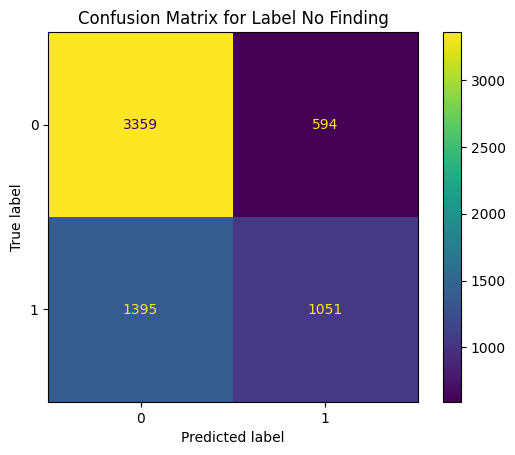

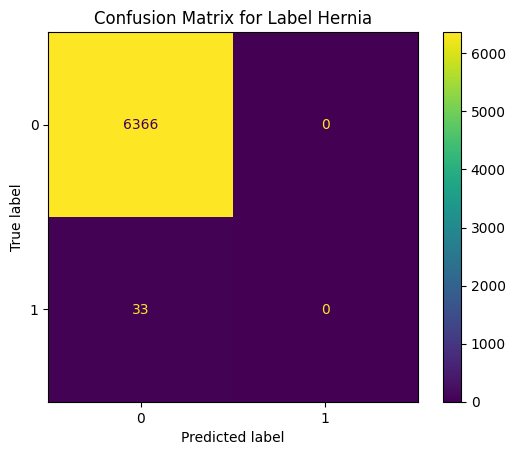

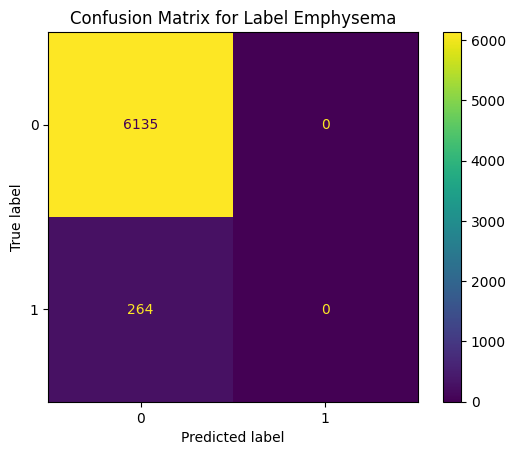

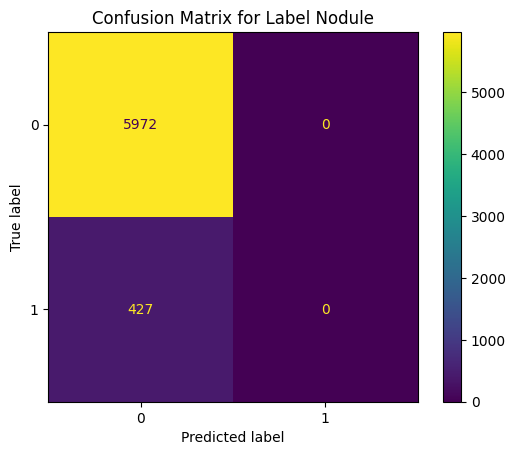

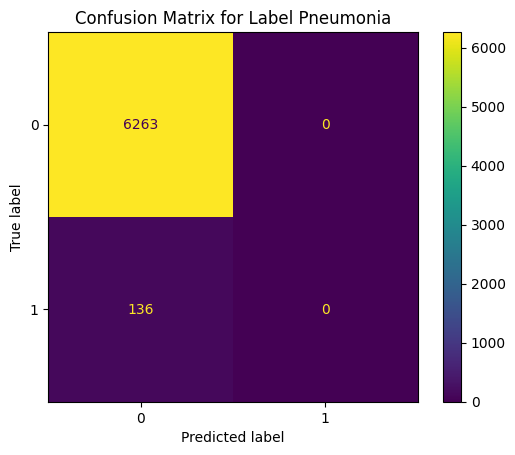

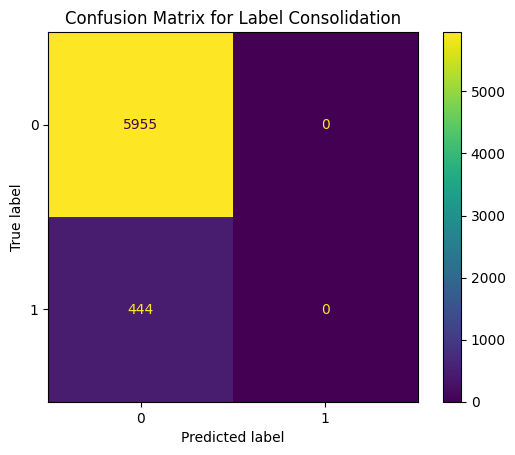

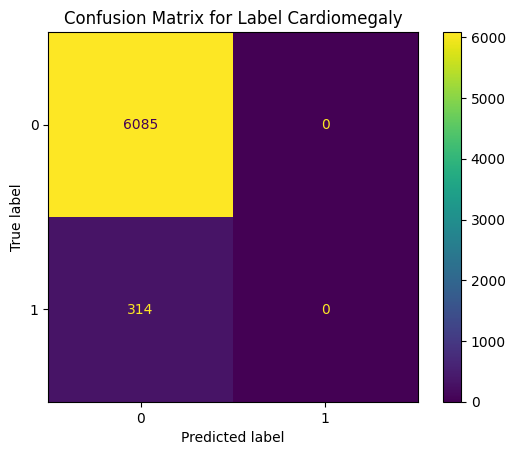

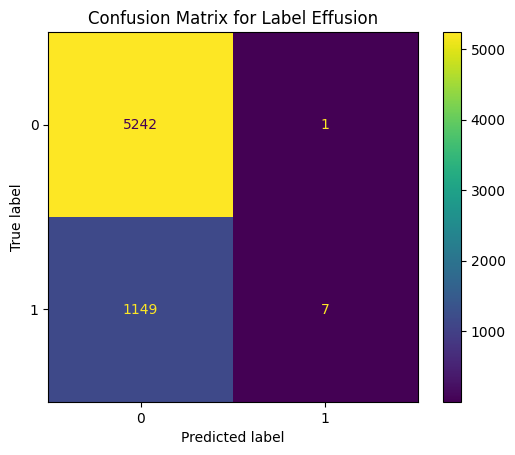

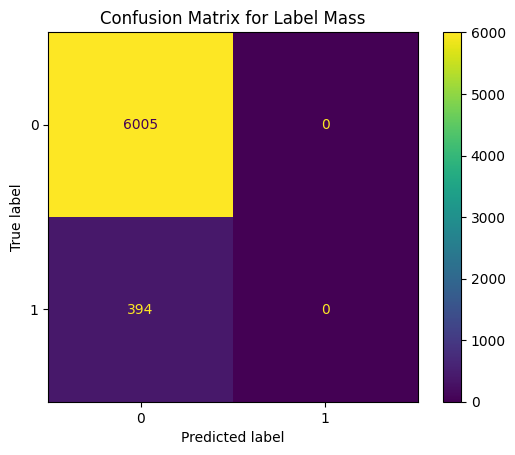

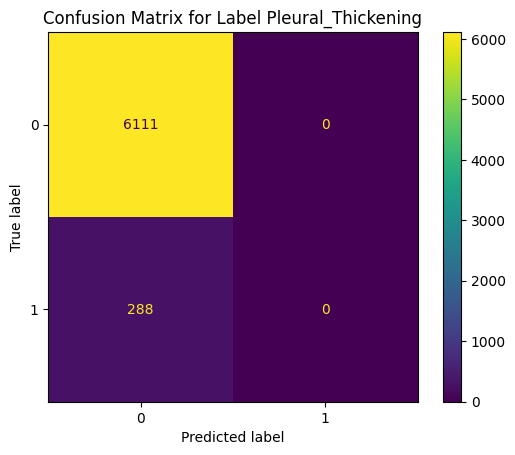

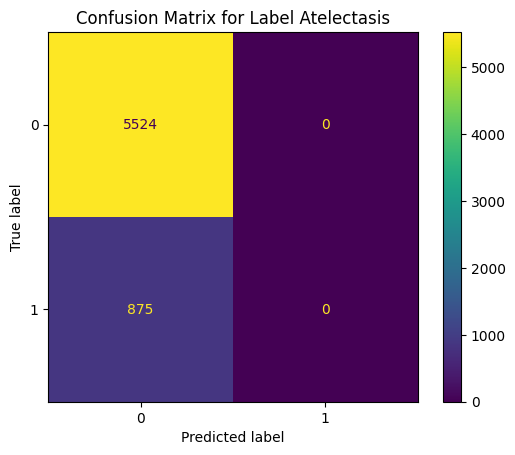

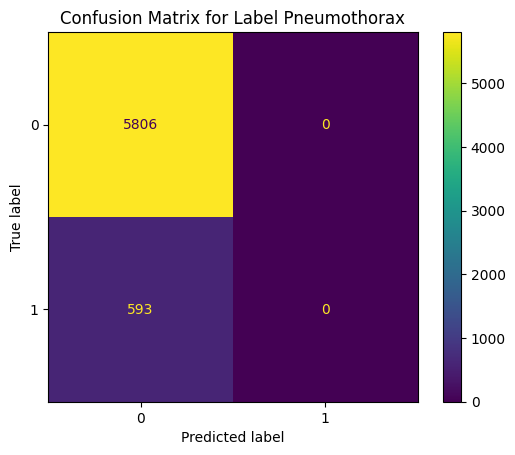

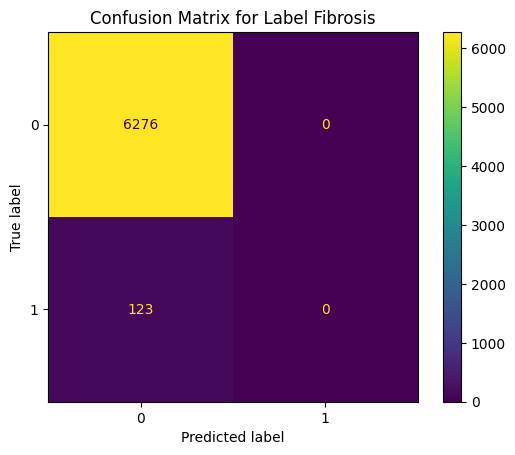

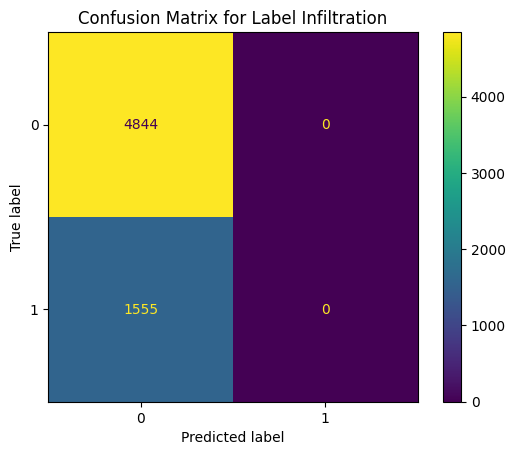

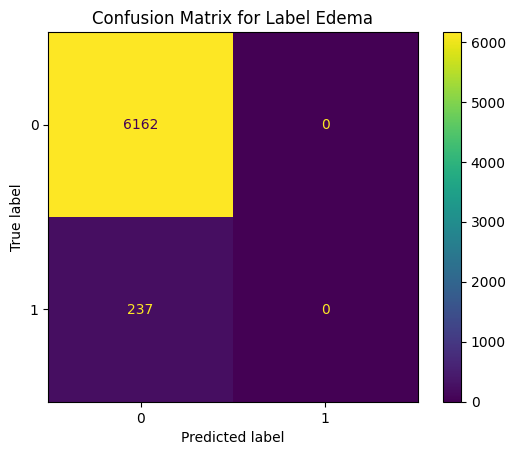

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

for i in range(cm.shape[0]):
    display = ConfusionMatrixDisplay(confusion_matrix=cm[i])
    fig, ax = plt.subplots()
    display.plot(ax=ax)
    plt.title(f"Confusion Matrix for Label {labels[i]}")
    plt.show()

In [15]:
def calculate_specificity(confusion_matrix):
    true_negatives = confusion_matrix[0, 0]
    false_positives = confusion_matrix[0, 1]
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

In [16]:
def calculate_sensitivity(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_negatives = confusion_matrix[1, 0]
    sensitivity = true_positives / (true_positives + false_negatives)
    return sensitivity

In [20]:
for i in range(len(cm)):
    specificities = calculate_specificity(cm[i])
    sensitivities = calculate_sensitivity(cm[i])
    print(f"Label {labels[i]}: Specificity = {specificities:.4f}, Sensitivity = {sensitivities:.4f}")

Label No Finding: Specificity = 0.8720, Sensitivity = 0.4047
Label Hernia: Specificity = 1.0000, Sensitivity = 0.0000
Label Emphysema: Specificity = 1.0000, Sensitivity = 0.0000
Label Nodule: Specificity = 1.0000, Sensitivity = 0.0000
Label Pneumonia: Specificity = 1.0000, Sensitivity = 0.0000
Label Consolidation: Specificity = 1.0000, Sensitivity = 0.0000
Label Cardiomegaly: Specificity = 1.0000, Sensitivity = 0.0000
Label Effusion: Specificity = 0.9981, Sensitivity = 0.0143
Label Mass: Specificity = 1.0000, Sensitivity = 0.0000
Label Pleural_Thickening: Specificity = 1.0000, Sensitivity = 0.0000
Label Atelectasis: Specificity = 1.0000, Sensitivity = 0.0000
Label Pneumothorax: Specificity = 1.0000, Sensitivity = 0.0000
Label Fibrosis: Specificity = 1.0000, Sensitivity = 0.0000
Label Infiltration: Specificity = 1.0000, Sensitivity = 0.0000
Label Edema: Specificity = 1.0000, Sensitivity = 0.0000


In [24]:
labels = test_ds.findings.info.class_names
print(labels)

['No Finding', 'Hernia', 'Emphysema', 'Nodule', 'Pneumonia', 'Consolidation', 'Cardiomegaly', 'Effusion', 'Mass', 'Pleural_Thickening', 'Atelectasis', 'Pneumothorax', 'Fibrosis', 'Infiltration', 'Edema']


In [25]:
len(test_ds)

6399

In [26]:
# Function to calculate multi-label accuracy
def accuracy_multi(preds, targs, thresh=0.5):
    preds = (preds.sigmoid() > thresh).float()
    return (preds == targs).float().mean()

In [40]:
# Containers to store predictions and true labels
all_preds = torch.tensor([]).to(device)
all_targs = torch.tensor([]).to(device)

# Go through the train_loader
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_preds = torch.cat((all_preds, output), dim=0)
        all_targs = torch.cat((all_targs, target), dim=0)

In [41]:
all_preds

tensor([[7.7769e-01, 6.5757e-05, 4.4797e-03,  ..., 6.7869e-03, 9.2821e-02,
         2.8526e-04],
        [2.8139e-01, 1.7101e-03, 3.1338e-02,  ..., 1.5820e-02, 1.1835e-01,
         1.2209e-02],
        [2.6904e-01, 3.2859e-03, 3.5761e-02,  ..., 2.3453e-02, 1.0868e-01,
         1.1252e-02],
        ...,
        [5.8022e-01, 5.5505e-04, 1.4749e-02,  ..., 1.5199e-02, 1.2181e-01,
         2.4438e-03],
        [4.6638e-01, 1.3231e-03, 2.4069e-02,  ..., 1.8766e-02, 1.0949e-01,
         5.1212e-03],
        [6.6489e-01, 2.5457e-04, 1.0203e-02,  ..., 1.0912e-02, 1.0925e-01,
         1.2512e-03]], device='cuda:0')

In [42]:
all_targs

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

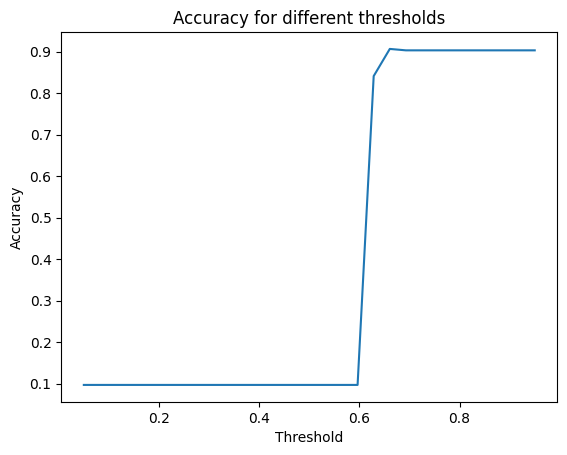

In [43]:
# Calculate accuracies for different thresholds
thresholds = torch.linspace(0.05, 0.95, 29).cpu().numpy()  # Convert to numpy array
accuracies = [accuracy_multi(all_preds.sigmoid(), all_targs, thresh=i).cpu().numpy() for i in thresholds]  # Convert to numpy array

# Plot the accuracies
plt.plot(thresholds, accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy for different thresholds")
plt.show()

In [46]:
thresh = 0.65
val_accuracy = accuracy_multi(all_preds, all_targs, thresh).item()
print(f'Epoch 1, Validation Accuracy: {val_accuracy}')

Epoch 1, Validation Accuracy: 0.9067562818527222


In [47]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [49]:
# Concatenate the results
all_preds_np = all_preds.cpu().numpy()
all_labels_np = all_targs.cpu().numpy()

# Calculate and print the F1 score, precision, and recall for each label
num_labels = all_labels_np.shape[1]
for label_index in range(num_labels):
    f1 = f1_score(all_labels_np[:, label_index], all_preds_np[:, label_index] > thresh, zero_division=1)
    precision = precision_score(all_labels_np[:, label_index], all_preds_np[:, label_index] >thresh, zero_division=1)
    recall = recall_score(all_labels_np[:, label_index], all_preds_np[:, label_index] > thresh, zero_division=1)

    print(f'Label {label_index} - F1 score: {f1}, Precision: {precision}, Recall: {recall}')

# Calculate micro and macro averaged F1 score, precision, and recall
micro_f1 = f1_score(all_labels_np, all_preds_np > thresh, average='micro', zero_division=1)
macro_f1 = f1_score(all_labels_np, all_preds_np > thresh, average='macro', zero_division=1)
micro_precision = precision_score(all_labels_np, all_preds_np > thresh, average='micro', zero_division=1)
macro_precision = precision_score(all_labels_np, all_preds_np > thresh, average='macro', zero_division=1)
micro_recall = recall_score(all_labels_np, all_preds_np > thresh, average='micro', zero_division=1)
macro_recall = recall_score(all_labels_np, all_preds_np > thresh, average='macro', zero_division=1)

print(f'Micro-averaged - F1 score: {micro_f1}, Precision: {micro_precision}, Recall: {micro_recall}')
print(f'Macro-averaged - F1 score: {macro_f1}, Precision: {macro_precision}, Recall: {macro_recall}')

Label 0 - F1 score: 0.4724521163395602, Precision: 0.5942891136228435, Recall: 0.3920722135007849
Label 1 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 2 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 3 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 4 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 5 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 6 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 7 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 8 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 9 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 10 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 11 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 12 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 13 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Label 14 - F1 score: 0.0, Precision: 1.0, Recall: 0.0
Micro-averaged - F1 score: 0.18231590473583356, Precision: 0.5942891136228435, Recall: 0.10767406768700151
Macro-averaged - F1 score: 0.03149680775597068, 

In [50]:
from sklearn.metrics import hamming_loss, jaccard_score

# Calculate Hamming Loss
hamming_loss_value = hamming_loss(all_labels_np, all_preds_np > thresh)
print(f'Hamming Loss: {hamming_loss_value}')

# Calculate Jaccard Index (Intersection over Union)
jaccard_index = jaccard_score(all_labels_np, all_preds_np > thresh, average='micro')
print(f'Jaccard Index: {jaccard_index}')


Hamming Loss: 0.09335833724019378
Jaccard Index: 0.10030120481927711


In [51]:
# Calculate Exact Match (Accuracy Exact Match)
exact_match = (all_labels_np == (all_preds_np > thresh)).all(axis=1).mean()
print(f'Exact Match (Accuracy Exact Match): {exact_match}')


Exact Match (Accuracy Exact Match): 0.15611814345991562
